In [1]:
bayesplay::loadpackages()

# Computing simple posteriors

For this section we'll leave **greta** behind. **Greta** is a great package for simple models; however, for more complex models—like regression models—we'll need a more power tool.  In this section, we're going to learn how to compute posteriors for means, standard deviations, correlation coefficients etc, but we're going to **frame** all of these problems **as regression**. This will allow use to use a powerful **R** package called **brms** to estimate these parameters. 

## Regression in R

If you're familiar with **regression** in **R** you should be familiar with **R**'s formula syntax. The formula syntax allows us to specify predictors and outcome variables in the following form: `outcome ~ 1 + predictor` where the `1` represents the intercept term. 

We can use this formula syntax to estimate means and correlations. For example, to estimate a mean for a one sample problem, we can just estimate the intercept using the following syntax `Y ~ 1`. 

In [2]:
# 1

lm.fit = lm(speed ~ 1, cars) 

summary(lm.fit)

glue::glue("the mean is {round(mean(cars$speed),4)}   
the Std. Error is {round(sd(cars$speed) / (sqrt(nrow(cars))),4)}") %>%
IRdisplay::display_markdown()



Call:
lm(formula = speed ~ 1, data = cars)

Residuals:
   Min     1Q Median     3Q    Max 
 -11.4   -3.4   -0.4    3.6    9.6 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  15.4000     0.7478   20.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.288 on 49 degrees of freedom


the mean is 15.4   
the Std. Error is 0.7478

We can also estimate a correlation by fitting a multivariate regression model, and then extracting the correlation from the variance-covariance matrix.


In [3]:
# 2

mvlm.fit = lm(cbind(speed,dist) ~ 1, cars)

glue::glue("correlation extracted from the variance-covariance matrix:
{round(vcov(mvlm.fit)[1,2] / (sqrt(vcov(mvlm.fit)[1,1]) * sqrt(vcov(mvlm.fit)[2,2])),3)}   
correlation calculated with the cor() function: {round(cor(cars$speed,cars$dist),3)}") %>%
IRdisplay::display_markdown()


correlation extracted from the variance-covariance matrix:
0.807   
correlation calculated with the cor() function: 0.807

Using the **brms** package we can do the same, but instead of just obtaining the point estimates (i.e., the maximum likelihood estimate) for our parameters we can obtain the entire posterior distribution! 


## Doing inference with posteriors

Doing inference with posterior distributions is a lot more intuitive than frequentist inference. I think it is also more intuitive than doing inference with **Bayes factors**. Bayesian parameter estimation similarly **re-allocates** belief. The *prior* distribution represents ours beliefs about parameter values **before** seeing any data, and the *posterior* represents our beliefs about parameter values after seeing the data. Beliefs about *parameter values* are fairly natural to think about. For example, a question like "Do we have a stronger belief that the mean difference is 0 or 10?" is naturally answered by examining the posterior probability distribution for the mean difference parameter and seeing whether the posterior probability of 0 is greater than the posterior probability for 10. 


## Estimating means for one sample problems 

[Kruschke (2013)](http://dx.doi.org/10.1037/a0029146) outlines an approach for estimating means for one and two group problems which can be used in place of one sample and two sample *t*-tests. These methods have been implemented in the **R** package **BEST**. However, these models are also straightforward to implement in **brms**, and doing so will help use to understand how they work. 

To start with, we're just going to use **brms** to estimate the intercept for a regression. We'll first do it without explicitly defining priors (we'll use the **brms** defaults which, incidently, are *t*-distributions), so that you can see that the syntax is the same as when use the **lm** function.

In [6]:
# 3
b.fit = brm(formula = speed ~ 1, data = cars, 
            chains = 4,  # number of mcmc chains to run
            iter = 2000, # number of iterations per chain
            seed = 5) # a seed for reproducibility

summary(b.fit)

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'a0df4817af22f62547ff18983331f654' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.017154 seconds (Warm-up)
Chain 1:                0.025253 seconds (Sampling)
Ch

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: speed ~ 1 
   Data: cars (Number of observations: 50) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    15.39      0.75    13.94    16.87 1.00     3273     2615

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     5.40      0.58     4.40     6.65 1.00     2969     2166

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

You'll see that the output is very similar to the output from `lm()`.


Now that we've got the basics down, let's define some priors. We'll use the same priors we used in the last section. Now we'll refit the model using these new priors.

First let's see what priors are already set.  

In [7]:
# 4
get_prior(formula = speed ~ 1, data = cars)


prior,class,coef,group,resp,dpar,nlpar,bound
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
"student_t(3, 15, 10)",Intercept,,,,,,
"student_t(3, 0, 10)",sigma,,,,,,


Now we'll set new priors are refit it. To know more about how **brms** parametrises distributions check out the [Stan manual](https://mc-stan.org/docs/2_22/functions-reference/index.html), because it's not always obvious (e.g., for *t* distributions the $\nu$ parameter comes first!)


In [8]:
# 5

priors = c(
prior("normal(0,1000)", class = "Intercept"),
prior("inv_gamma(1,10)", class = "sigma")
)

b.fit2 = brm(formula = speed ~ 1, data = cars, 
             prior = priors, # set the priors
            chains = 4,  # number of mcmc chains to run
            iter = 2000, # number of iterations per chain
            seed = 5) # a seed for reproducibility

summary(b.fit2)

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'f167aae1937c8e7b0fedb02a557d7c4e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.020401 seconds (Warm-up)
Chain 1:                0.015059 seconds (Sampling)
Ch

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: speed ~ 1 
   Data: cars (Number of observations: 50) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    15.40      0.79    13.88    16.94 1.00     2833     2353

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     5.42      0.56     4.47     6.59 1.00     2569     2234

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

And we'll draw some histograms of our posteriors. 

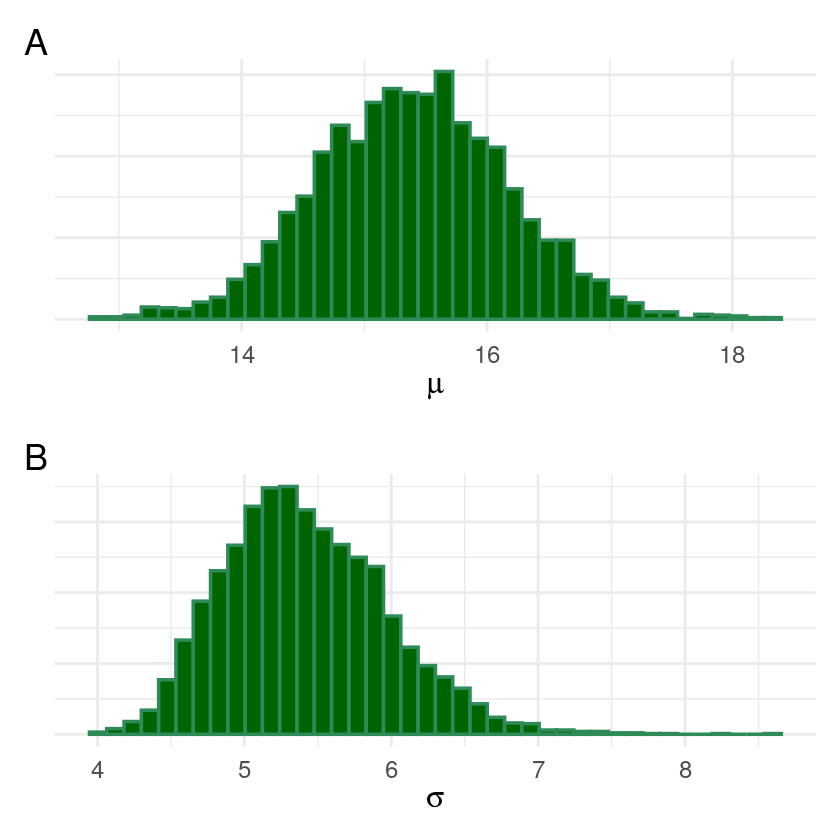

In [9]:
# 6 

post = posterior_samples(b.fit2) %>% select(1:2) %>% set_colnames(c("mu","sigma"))


mu_plot = ggplot(post) + geom_histogram(aes(x = mu), bins = 40, fill = "darkgreen", colour = "seagreen", size = 1) + 
theme_minimal(18) + scale_y_continuous(name = NULL, labels = NULL) + 
scale_x_continuous(name = expression(mu))

sigma_plot = ggplot(post) + geom_histogram(aes(x = sigma), bins = 40, fill = "darkgreen", colour = "seagreen", size = 1) + 
theme_minimal(18) + scale_y_continuous(name = NULL, labels = NULL) + 
scale_x_continuous(name = expression(sigma))

mu_plot / sigma_plot + plot_annotation(tag_levels = "A")

 This approach works will if we have nicely behaved data. However, this isn't always the case. Often when we have small sample sizes we can have outliers and these outliers can affect our estimates for the mean. We'll illustrate this by generating some data and then adding a view outliers.


the clean data has a mean of 120 and an sd of 15   
the noisy data has a mean of 124.83 and an sd of 25.1   

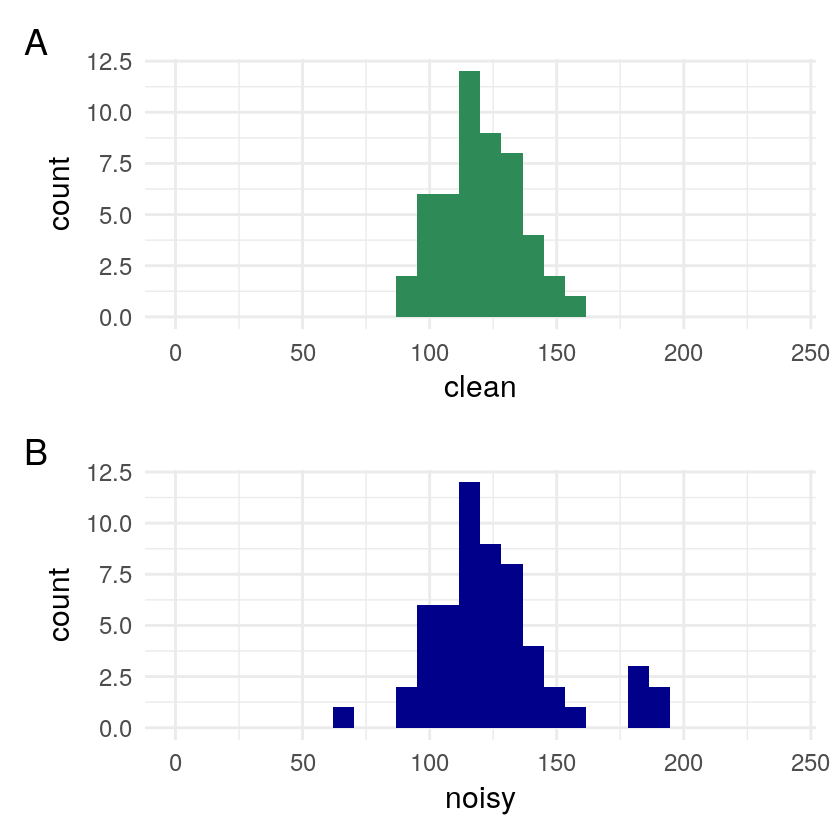

In [17]:
# 6

# generate some data with a set mean and sd

set.seed(123)

# set number of CPU cores
n_cores = 6

# lets generate some data specific characteristics
mean = 120
sd = 15

# we'll generate N data point
N = 50

clean_data = as.numeric(mean + sd * scale(rnorm(n = N, 0, 1)))


# now add some outliers
outliers = map_df(1:6, function(x) tibble(sds = runif(1,3, 5), pos_neg = sign(runif(1,-1,3)))) %>%
       mutate(d = mean + (pos_neg * sds * sd) ) %>% pull(d)
                  
noisy_data = c(clean_data,outliers)                  

glue::glue("the clean data has a mean of {round(mean(clean_data),2)} and an sd of {round(sd(clean_data),2)}   
the noisy data has a mean of {round(mean(noisy_data),2)} and an sd of {round(sd(noisy_data),2)}   ") %>% 
IRdisplay::display_markdown()
                  
clean_plot = ggplot() + geom_histogram(aes(x = clean_data), bins = 30, fill = "seagreen", na.rm = T) + 
                  scale_x_continuous(limits = c(mean-(8 * sd), mean + (8 * sd)), name = "clean") + 
                  theme_minimal(18)     
noisy_plot = ggplot() + geom_histogram(aes(x = noisy_data), bins = 30, fill = "darkblue", na.rm = T) +
                  scale_x_continuous(limits = c(mean-(8 * sd), mean + (8 * sd)), name = "noisy") + 
                  theme_minimal(18)     
                  
(clean_plot / noisy_plot) + plot_annotation(tag_levels = "A")            

Usually the frequentist way to deal with this is to employ some **robust** estimate of central tendency like using a **median** instead of a **mean**.

How might we deal with this within a Bayesian estimation approach? There's a long history of using *t* distributions, instead of *normal* distributions, to describe data with outliers, and this is the approach used by Kruschke (2013). The *t* distribution has an additional parameter ($\nu$) which describes the **fatness** of the tails. Having fat tails allows the *t* distribution to be fit to data without outliers impacting the estimates for the $\mu$ and $\sigma$ parameters. Let's see this in action with an example. We'll start off by not explicitly defining priors (and using the **brms** defaults) before we discuss Kruschke's (2013) choices and some alternatives. 



First we'll estimate the $\mu$ and $\sigma$ using a **normal distribution** and then do the same using a **t** distribution


In [18]:
# 7

# specify the mode
model = bf(Y ~ 1)

# turn the data into a tibble
noisy_df = tibble(Y = noisy_data)

# first fit with a normal distribution
fit_normal = brm(model, data = noisy_df, chains = 4, cores = n_cores, family = gaussian, silent = T)

# then first with a t dist
fit_t = brm(model, data = noisy_df, chains = 6, cores = n_cores, family = student, silent = T)


Compiling the C++ model

Start sampling

Compiling the C++ model

Start sampling



Now we'll draw a plot of the two fits. To do this, we'll construct a normal distribution and a *t* distribution. We'll use the most probably value from the posterior distribution for each parameter. This will be the **mode** of each posterior—this is known as the maximum a posteriori probability (MAP) estimate. 


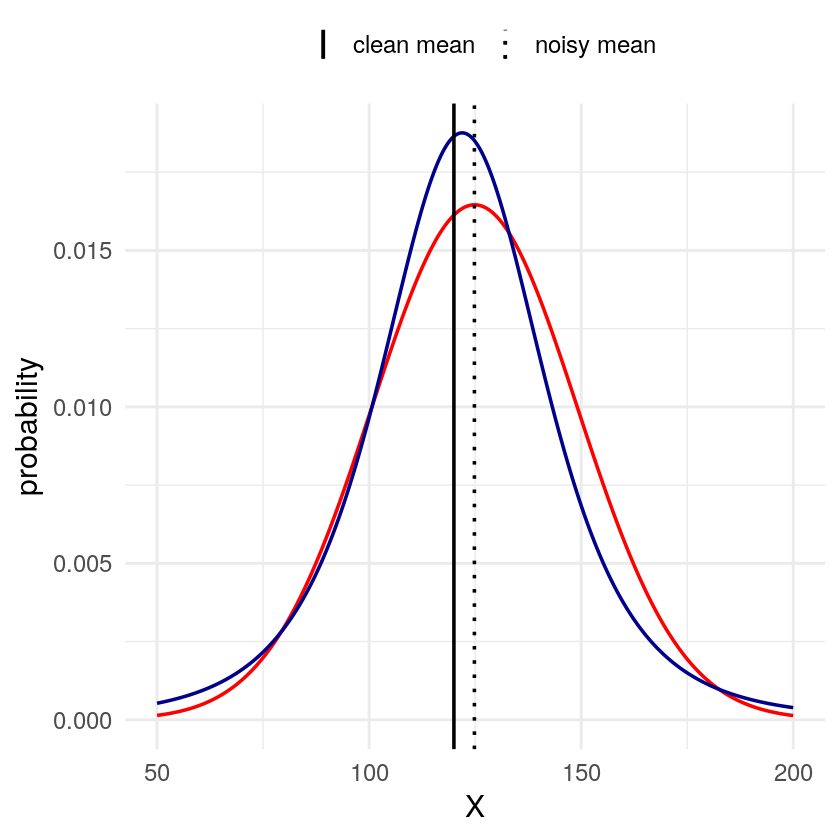

In [23]:
# 8

mcmc_normal = posterior_samples(fit_normal) %>% select(1:2) %>% set_colnames(c("mu","sigma"))
mcmc_t = posterior_samples(fit_t) %>% select(1:3) %>% set_colnames(c("mu","sigma","nu"))


post_normal = map_df(mcmc_normal,function(x) tidybayes::mode_hdi(x)) %>% add_column(parameter = names(mcmc_normal), .before = 1)

post_t = rbind(map_df(mcmc_t[1:2],function(x) tidybayes::mode_hdi(x)) %>% add_column(parameter = names(mcmc_normal)[1:2], .before = 1),
             tidybayes::mode_hdi(log10(mcmc_t$nu)) %>% add_column(parameter = "log10(nu)", .before = 1))
post_t = rbind(post_t, 
      post_t %>% slice(3) %>% mutate(parameter = "nu", 
                              y = 10^y, 
                              ymin = 10^ymin,
                              ymax = 10^ymax))

               
xvals = seq(0,250, length.out = 10000)
map_normal_df = tibble(x = xvals) %>% 
               mutate(y = dnorm(x = x, 
                                mean = post_normal %>% filter(parameter == "mu") %>% pull(y), 
                                sd = post_normal %>% filter(parameter == "sigma") %>% pull(y)))
               
map_t_df = tibble(x = xvals) %>% 
               mutate(y = dt.scaled(x = x, 
                                mean = post_t %>% filter(parameter == "mu") %>% pull(y), 
                                sd = post_t %>% filter(parameter == "sigma") %>% pull(y),
                                df = post_t %>% filter(parameter == "nu") %>% pull(y))) 
               
ggplot() + 
geom_line(data = map_normal_df, mapping = aes(x = x, y = y, colour = "normal"), size = 1, na.rm = T) +
geom_line(data = map_t_df, mapping = aes(x = x, y = y, colour = "t"), size = 1, na.rm = T) + 
geom_vline(mapping = aes(xintercept = mean(clean_data), linetype = "clean"), size = 1) +               
geom_vline(mapping = aes(xintercept = mean(noisy_data), linetype = "noisy"), size = 1) +   
scale_x_continuous(limits = c(50,200), name = "X") +
scale_y_continuous(name = "probability") +               
scale_colour_manual(values = c("red","darkblue"), name = NULL, guide = "none") +                
scale_linetype_manual(values = c(1,9), labels = c("clean mean","noisy mean"), name = NULL) +
theme_minimal(18) + theme(legend.position = "top") 

In [24]:
# 9

post_normal %>% slice(c(1:2,4)) %>% select(1:4) %>%
mutate(parameter = recode("mu" = "$\\mu$",
                          "sigma" = "$\\sigma$",
                          "nu" = "$\\nu$", parameter)) %>%
set_colnames(c("parameter","mode","lower","upper")) %>%
knitr::kable(digits = 2, format = "html", caption = "posterior summary for normal fit") %>%
kableExtra::kable_styling(full_width = F) %>% 
as.character() %>% IRdisplay::display_markdown()

post_t %>% slice(c(1:2,4)) %>% select(1:4) %>%
mutate(parameter = recode("mu" = "$\\mu$",
                          "sigma" = "$\\sigma$",
                          "nu" = "$\\nu$", parameter)) %>%
set_colnames(c("parameter","mode","lower","upper")) %>%
knitr::kable(digits = 2, format = "html", caption = "posterior summary for $t$ fit") %>%
kableExtra::kable_styling(full_width = F) %>% 
as.character() %>% IRdisplay::display_markdown()


<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>posterior summary for normal fit</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> parameter </th>
   <th style="text-align:right;"> mode </th>
   <th style="text-align:right;"> lower </th>
   <th style="text-align:right;"> upper </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> $\mu$ </td>
   <td style="text-align:right;"> 124.87 </td>
   <td style="text-align:right;"> 118.04 </td>
   <td style="text-align:right;"> 130.74 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> $\sigma$ </td>
   <td style="text-align:right;"> 24.24 </td>
   <td style="text-align:right;"> 20.80 </td>
   <td style="text-align:right;"> 29.92 </td>
  </tr>
</tbody>
</table>

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>posterior summary for $t$ fit</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> parameter </th>
   <th style="text-align:right;"> mode </th>
   <th style="text-align:right;"> lower </th>
   <th style="text-align:right;"> upper </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> $\mu$ </td>
   <td style="text-align:right;"> 121.94 </td>
   <td style="text-align:right;"> 116.13 </td>
   <td style="text-align:right;"> 128.02 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> $\sigma$ </td>
   <td style="text-align:right;"> 19.93 </td>
   <td style="text-align:right;"> 12.88 </td>
   <td style="text-align:right;"> 26.49 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> $\nu$ </td>
   <td style="text-align:right;"> 3.79 </td>
   <td style="text-align:right;"> 1.69 </td>
   <td style="text-align:right;"> 29.09 </td>
  </tr>
</tbody>
</table>

We can see from the plot and the table that the estimates for $\mu$ and $\sigma$ are closer to the mean and sd for the clean data when we fit the model with a *t* distribution. 

Now that's we fit the basic model, we'll make some changes to the priors. Kruschke (2013) makes the following choices for priors: 

1. For $\mu$, a very wide normal distribution centred at the sample mean and with a standard deviation of 1000 times the sample sd

2. For $\sigma$, a very wide uniform distribution ranging from $\frac{\mathrm{sd}}{1000}$ to $\mathrm{sd}\times1000$

3. For $\nu$, a shifted exponential with a scale of 1/29

The paper gives more details on the prior choice, but the reasoning, in simple terms, the priors for $\mu$ and $\sigma$ are chosen so as to have as little influence on the posterior as possible (that is, to allow the data to dominate). The prior for $\nu$ is chosen because it has a mean of about 30, which balanced the prior weight between values below 30 and values above 30. When $\nu$ is above 30 the *t* distribution is almost normal. Therefore, this prior provides a balance between values of $\nu$ that correspond to fat-tailed and normal-like distributions. 

We'll define the priors as outlined in Kruschke (2013) and refit the model.


Compiling the C++ model

Start sampling



,Estimate,Est.Error,Q2.5,Q97.5
b_Intercept,121.98719,3.226877,116.062288,128.72497
sigma,19.24726,4.066429,12.299856,27.55573
nu,10.72943,16.444849,1.644235,61.08427
lp__,-278.19165,1.259506,-281.429133,-276.68704


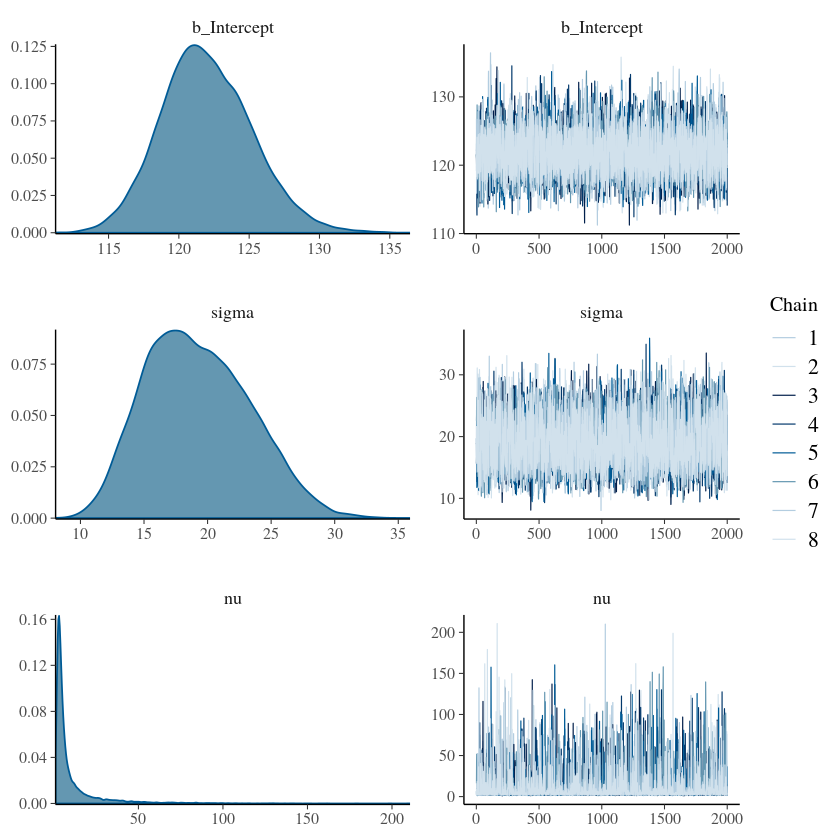

In [25]:
# 10
# fit the model using Kruschke's priors
mean_y = mean(noisy_data)
sd_y = sd(noisy_data)

# define variables 
# we need to do this so we can use these variables for defining prirors
stanvars <- 
  stanvar(mean_y, name = "mean_y") + 
  stanvar(sd_y,   name = "sd_y") + 
  stanvar(1/29,   name = "expv")

kruschke_priors = c(prior(normal(mean_y, sd_y * 1000), class = Intercept),
                prior(uniform(sd_y/1000, sd_y * 1000), class = sigma),
                prior(exponential(expv), class = nu))

fit_kruschke = brm(data = noisy_df, silent = T,
      family = student,
      Y ~ 1, iter = 4000,
      prior = kruschke_priors,
      chains = 8, cores = 8,
      stanvars = stanvars,
      seed = 16)


# now work out some summary stats
posterior_summary(fit_kruschke) %>% knitr::kable(format = "html") %>% 
as.character() %>% IRdisplay::display_html()

# now plot the posteriors and the mcmc chains
plot(fit_kruschke)



We'll see that the priors didn't make much of a difference. We will, however, make a couple of changes from Kruschke (2013) choices. Specifically, we'll change the priors for $\mu$ and $\sigma$. The $\mu$ prior is unnecessarily wide. We'll tighten it up so that our sampler doesn't spend to much time exploring obviously ridiculous values. However, we'll still keep it wide by setting the sd of the prior to 100 (instead 1000). Uniform priors are generally discouraged, so we'll change our $\sigma$ prior from a uniform to something else. For this, we could use something like a **gamma** distribution (which is restricted to non-negative values) or something like a **half-normal**, **half-t** or **half-cauchy** distribution, which again would be restricted to positive values. We'll pick a **half-normal**. This will be centred at 0, and we'll set the sd to our observed sd. This places most of the weight at values between zero and the observed value, but it extends the range of plausible values all the way up to $+\infty$. Let's try out these new priors and refit the model. 

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'f71a9316b7be4165900b942dd7b29075' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Warmup)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Warmup)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Warmup)
Chain 1: Iteration: 2001 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.102956 seconds (Warm-up)
Chain 1:                0.095275 seconds (Sampling)
Chain 1: 

,Estimate,Est.Error,Q2.5,Q97.5
b_Intercept,121.923263,3.185052,116.119961,128.64380
sigma,18.827598,3.907455,12.223471,26.69874
nu,9.920904,16.554642,1.621406,58.07152
lp__,-269.450786,1.283687,-272.826679,-267.92329


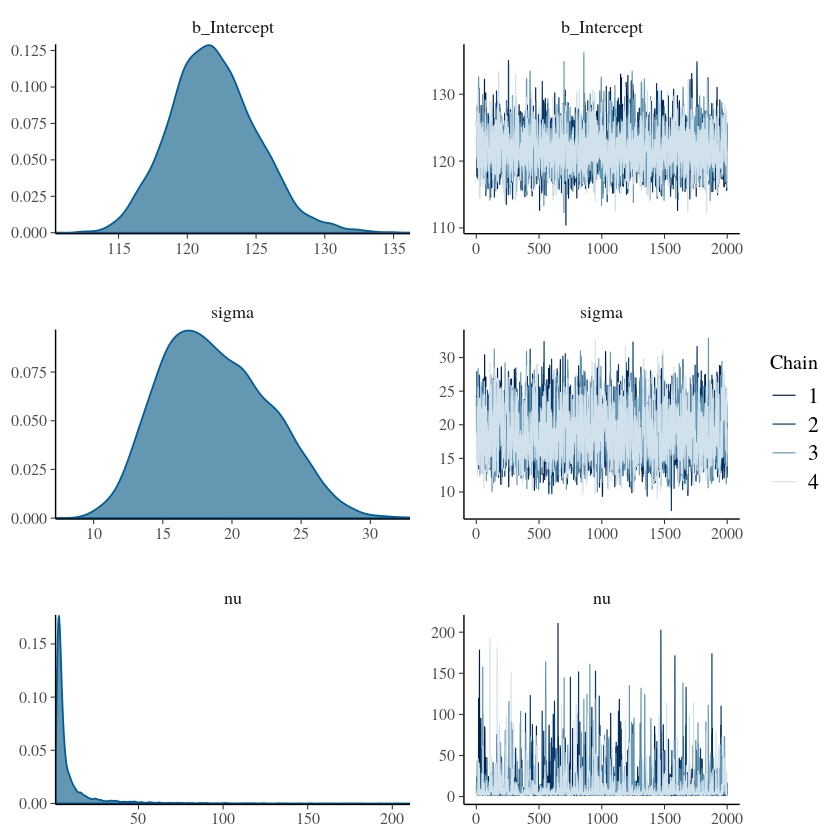

In [26]:
# 11
# fit the model using some slightly different priors

weak_priors = c(prior(normal(mean_y, sd_y * 100), class = Intercept),
                prior(normal(0, sd_y), class = sigma),
                prior(exponential(expv), class = nu))

weak_fit = brm(data = noisy_df, silent = T,
      family = student,
      Y ~ 1, iter = 4000,
      prior = weak_priors,
      chains = 4,
      stanvars = stanvars,
      seed = 16)

posterior_summary(weak_fit) %>% knitr::kable(format = "html") %>% 
as.character() %>% IRdisplay::display_html()

# now plot the posteriors and the mcmc chains
plot(weak_fit)


We can see that the two posteriors are very similar. In the second set the $\sigma$ has moved ever so slightly closer to 0, as you'd expect. The $\nu$ parameter has also shrunk slightly, indicating a preference to slightly fatter tails.


## Estimating means for two sample problems 

To extend this idea to two sample problems is trivial. All we do is add group as predictor. By default **brms** will estimate a single $\sigma$, so we'll also have to specify that we want a $\sigma$ for each group. Following Kruschke (2013) we'll just estimate one $\nu$ . There's also a couple of ways to parametrise this in **brms**. We could, for example, estimate a intercept and a $\beta$. The mean of group 1 would then correspond to the intercept and the mean of group 2 would be the intercept + $\beta$. However, we could instead fit two intercepts (one for group 1 and one for group 2). This is the approach we'll take. 

A second thing to note it that when we're estimating $\sigma$ in our model **brms** will default to modelling $\mathrm{log}(\sigma)$. As a result, we'll make sure our prior for $\sigma$ is appropriately scaled by $\mathrm{log}(\sigma)$ rather than $\sigma$. We'll just convert it out of the log scale once we have the posteriors. 

The priors we need to define for the two group case will be labelled slightly differently. To see what the parameters are called, we'll use the `get_prior()` function from **brms**. We'll first have to define some data, and then use `get_prior()`

In [27]:
# 12

# make some data

mean1 = 20; mean2 = 35
sd1 = 15; sd2 = 12
N1 = 10; N2 = 20

Y1 = as.numeric(mean1 + sd1 * scale(rnorm(n = N1, 0, 1)))
Y2 = as.numeric(mean2 + sd2 * scale(rnorm(n = N2, 0, 1)))

two_group_df = rbind(tibble(Y = Y1, G = "1"),
                  tibble(Y = Y2, G = "2"))


# define the two group model
two_group_model = bf(Y ~ 0 + G, sigma ~ 0 + G)

# get the prior
get_prior(two_group_model, two_group_df, family = student)

prior,class,coef,group,resp,dpar,nlpar,bound
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,
,b,G1,,,,,
,b,G2,,,,,
"gamma(2, 0.1)",nu,,,,,,
,b,,,,sigma,,
,b,G1,,,sigma,,
,b,G2,,,sigma,,


Let's try fitting it now.

In [28]:
# 13

# define some variables

mean_y = mean(two_group_df$Y) # use the grand mean
sd_y = sd(two_group_df$Y) # use the grand sd
stanvars <- 
  stanvar(mean_y, name = "mean_y") + 
  stanvar(sd_y,   name = "sd_y") + 
  stanvar(1/29,   name = "expv")

# first define the priors
two_group_priors = c(prior(normal(mean_y, sd_y * 100), class = b),
                    prior(normal(0, sd_y), class = b, dpar = sigma),
                    prior(exponential(expv), class = nu))

# now fit it!
two_group_fit = brm(data = two_group_df, stanvars = stanvars, silent = T,
      family = student,
      bf(Y ~ 0 + G, sigma ~ 0 + G), iter = 4000,
      chains = 8, cores = 8,
      seed = 16)


Compiling the C++ model

Start sampling



And now we'll draw some plots and make some summaries.

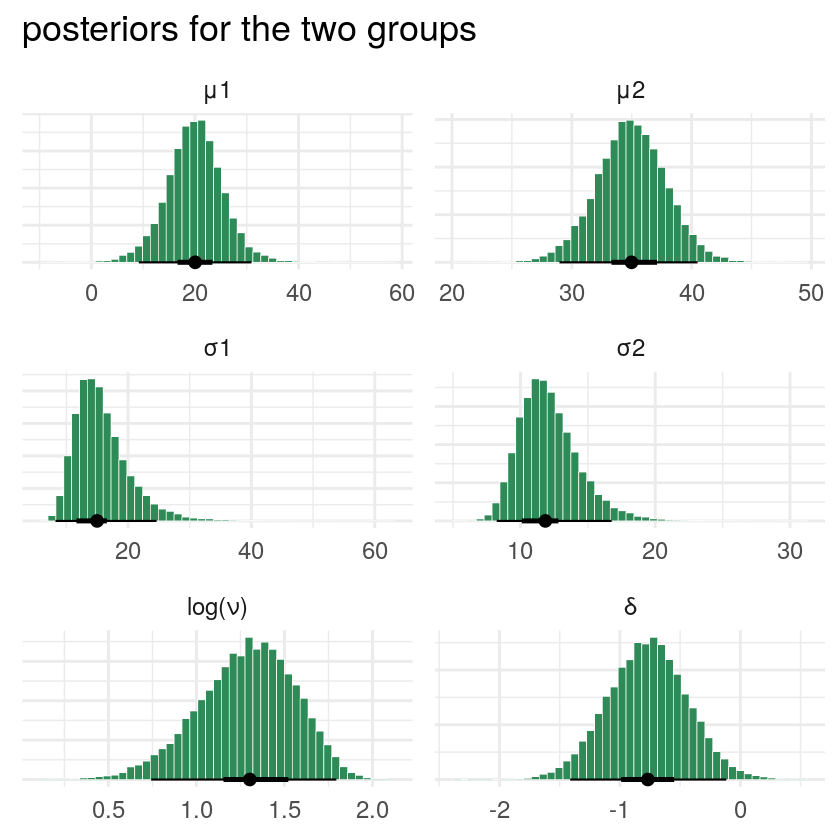

In [31]:
# 14

# get the posterior samples
two_group_mcmc = posterior_samples(two_group_fit) %>% select(1:5) %>% 
set_colnames(c("mu1","mu2","sigma1","sigma2","nu")) %>%
mutate(sigma1 = exp(sigma1), sigma2 = exp(sigma2))

# plot the posteriors nicely, and add an additional 

two_group_mcmc %>% mutate(nu = log10(nu), sigma1 = sigma1, sigma2 = sigma2) %>% # log nu 
mutate(effz = (mu1 - mu2) / sqrt((sigma1^2 + sigma2^2))) %>% # calculate an effect size!s
pivot_longer(cols = c("mu1","mu2","sigma1","sigma2","nu","effz"), names_to = "param") %>%
mutate(param = factor(param, levels = c("mu1","mu2","sigma1","sigma2","nu","effz"))) %>%
ggplot() + geom_histogram(aes(x = value), fill = "seagreen", color = "white", size = .2, bins = 45) + 
theme_minimal(18) + 
tidybayes::stat_pointintervalh(aes(x = value, y = 0), 
point_interval = tidybayes::median_hdi, .width = c(.5, .95)) + 
facet_wrap(~param, scales = "free", nrow = 3, 
labeller = labeller(param = c("mu1" = "μ1", 
                              "mu2" = "μ2", 
                              "sigma1" = "σ1", 
                              "sigma2" = "σ2",
                             "nu" = "log(ν)",
                             "effz" = "δ"))) + 
scale_y_continuous(NULL, labels = NULL) + 
scale_x_continuous(NULL) + labs(title = "posteriors for the two groups")

Now that we've estimated $\mu$ for the two groups how to we go about examining the group difference? The great thing about working with posterior distributions is that we can just **subtract** them! The difference between $\mu_1$ and $\mu_2$ will be the posterior of our group difference. We can do the same for $\sigma_1$ and $\sigma_2$.


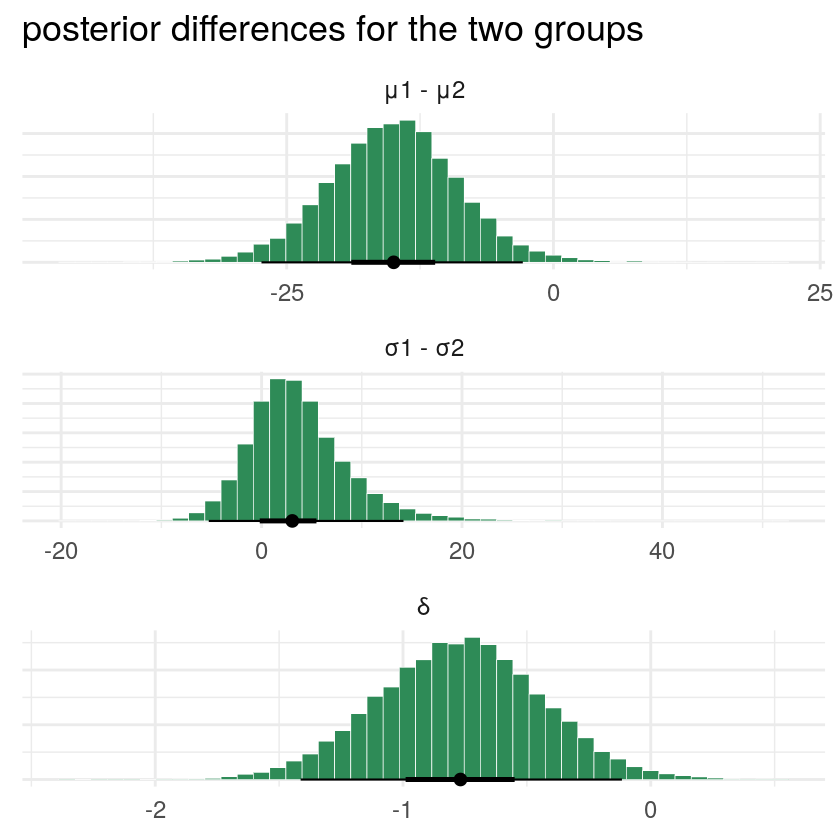

In [32]:
# 15

two_group_mcmc %>% 
mutate(effz = (mu1 - mu2) / sqrt((sigma1^2 + sigma2^2))) %>%
mutate(mu_diff = mu1 - mu2, sigma_diff = sigma1 - sigma2) %>% select(mu_diff,sigma_diff,effz) %>%
pivot_longer(cols = c("mu_diff","sigma_diff","effz"), names_to = "param") %>%
mutate(param = factor(param, levels = c("mu_diff","sigma_diff","effz"))) %>%
ggplot() + geom_histogram(aes(x = value), fill = "seagreen", color = "white", size = .2, bins = 45) + 
theme_minimal(18) + 
tidybayes::stat_pointintervalh(aes(x = value, y = 0),
point_interval = tidybayes::median_hdi, .width = c(.5, .95)) + 
facet_wrap(~param, scales = "free", nrow = 3, 
labeller = labeller(param = c("mu_diff" = "μ1 - μ2", 
                              "sigma_diff" = "σ1 - σ2", 
                             "effz" = "δ"))) + 
scale_y_continuous(NULL, labels = NULL) + 
scale_x_continuous(NULL) + labs(title = "posterior differences for the two groups")


# Estimating correlations

To extend this idea to correlations is also straightforward. I'll start off by generating some data and calculating the correlation.

The Pearson's product-moment correlation is -0.55 
(95% CI [-0.74, -0.29])

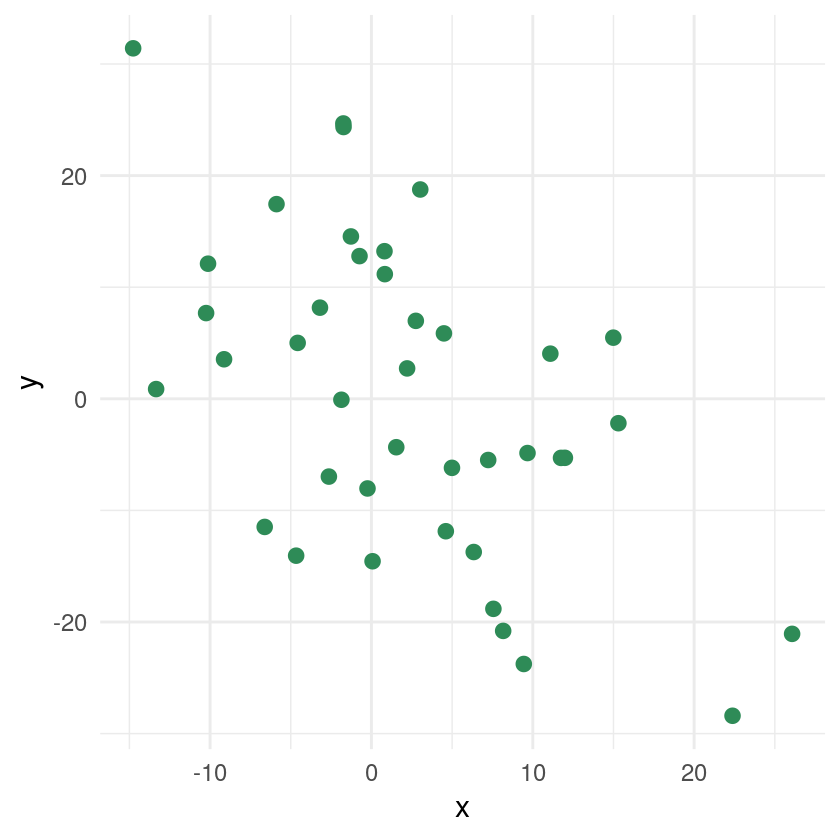

In [33]:
#16
set.seed(588)

sigma = c(10, 15)  # the sds
means = c(20, 28)  # the means
rho   = -.55      # the  correlation
N = 40
# construct the covariance matrix
sigma.mat = matrix(c(
    sigma[1] ^ 2, sigma[1] * sigma[2] * rho,
    sigma[1] * sigma[2] * rho,sigma[2] ^ 2),
         nrow = 2, byrow = T)

# generate some data!
clean_cor_df = mvtnorm::rmvnorm(n = N, sigma = sigma.mat) %>% 
set_colnames(c("x","y")) %>% as_tibble()
cor.test(clean_cor_df$x,clean_cor_df$y) %>% 
broom::tidy() %>% glue::glue_data("The {method} is {round(estimate,2)} 
(95% CI [{round(conf.low,2)}, {round(conf.high,2)}])") %>% 
IRdisplay::display_markdown()


ggplot(clean_cor_df, aes(x = x, y = y)) + geom_point(size = 4, colour = "seagreen")  + 
theme_minimal(18)

I'll also add a few outliers see how how it throws off the correlation.

# add a couple of points to try throw the correlation off

noisy_cor_df = rbind(clean_cor_df,tibble(x = c(20,15,-30), y = c(40,30,-30)))

noisy_cor_df$outlier = 0

noisy_cor_df$outlier[41:43] = 1


cor.test(noisy_cor_df$x,noisy_cor_df$y) %>% 
broom::tidy() %>% glue::glue_data("The {method} is {round(estimate,2)} 
(95% CI [{round(conf.low,2)}, {round(conf.high,2)}])") %>% 
IRdisplay::display_markdown()


ggplot(noisy_cor_df, aes(x = x, y = y)) + geom_point(size = 4, aes(colour = as.factor(outlier))) + 
scale_colour_manual(values = c("seagreen","darkblue"), guide = "none")+ 
theme_minimal(18)

Now we'll try estimate it with **brms**. We'll do this by estimating the paramters of a multivariate *t* distribution. Because it's a multivariate distribution, **brms** will automatically estimate a correlation parameter. We can explictly define a prior for that parameter. The `ljk()` piror can just be thought of a as **Beta** distribution with $\alpha$ = $\beta$. So `ljk(1)` just means **Beta(1,1)**, which, as you'll remember, is a uniform distribution.

In [37]:
cor.fit = brm(data = noisy_cor_df, family = student,
      mvbind(x, y) ~ 1,
      prior = c(prior(gamma(2, .1), class = nu),
                prior(normal(0, 100), class = Intercept),
                prior(normal(0, 100), class = sigma, resp = x),
                prior(normal(0, 100), class = sigma, resp = y),
                prior(lkj(1), class = rescor)),
      iter = 2000, warmup = 500, chains = 4,
      seed = 210191)

Setting 'rescor' to TRUE by default for this model

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'a47b24c3684819c79286eb72edee8391' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000185 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.85 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  501 / 2000 [ 25%]  (Sampling)
Chain 1: Iteration:  700 / 2000 [ 35%]  (Sampling)
Chain 1: Iteration:  900 / 2000 [ 45%]  (Sampling)
Chain 1: Iteration: 1100 / 2000 [ 55%]  (Sampling)
Chain 1: Iteration: 1300 / 2000 [ 65%]  (Sampling)
Chain 1: Iteration: 1500 / 2000 [ 75%]  (Sampling)
Chain 1: Iteration: 1700 / 2000 [ 85%]  (Sampling)
Chain 1: Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.444892 seconds (Warm-up)
Chain 1:                0.697652 seconds (Sam

In [38]:
summary(cor.fit)


 Family: MV(student, student) 
  Links: mu = identity; sigma = identity; nu = identity
         mu = identity; sigma = identity; nu = identity 
Formula: x ~ 1 
         y ~ 1 
   Data: noisy_cor_df (Number of observations: 43) 
Samples: 4 chains, each with iter = 2000; warmup = 500; thin = 1;
         total post-warmup samples = 6000

Population-Level Effects: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
x_Intercept     2.27      1.56    -0.77     5.42 1.00     6987     4110
y_Intercept     1.02      2.51    -3.93     6.00 1.00     7157     4342

Family Specific Parameters: 
        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma_x     9.47      1.34     7.04    12.41 1.00     5615     4302
sigma_y    15.14      2.02    11.64    19.68 1.00     5522     4595
nu         13.18      9.70     3.39    39.31 1.00     5501     5105

Residual Correlations: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
rescor(x,y)    -0.21 